In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [30]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)


In [31]:
def neural_network_solution(input_dimension, output_dimension, number_hidden_layers, hidden_neurons, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    layers = []
    
    # Add input layer
    layers.append(nn.Linear(input_dimension, hidden_neurons))
    layers.append(nn.ReLU())
    
    # Add hidden layers
    for _ in range(number_hidden_layers - 1):
        layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        layers.append(nn.Tanh())
    
    # Add output layer
    layers.append(nn.Linear(hidden_neurons, output_dimension))
    
    # Construct the sequential model
    model = nn.Sequential(*layers)
    
    return model

In [32]:
class Exact():
    def __init__(self, file):
        exact = pd.read_table(file, sep=',')
        self.t = exact.t.values
        self.x = exact.x.values
        self.tf = exact.tf.values
        
    def get_t(self):
        return self.t
    
    def get_x(self):
        return self.x
    
    def get_tf(self):
        return self.tf
    
    def get_t_x_tensor(self):
        return torch.Tensor(np.column_stack((self.t, self.x)))
    
    def get_tf_tensor(self):
        return torch.Tensor(self.tf)

In [50]:
def U_f(t):
    if (t >= 0 and t < 1) or (t >= 4 and t < 5):
        return 1.
    elif (t >= 1 and t < 2) or (t >= 5 and t < 6):
        return 0.
    elif (t >= 2 and t < 3) or (t >=6 and t < 7):
        return -1.
    elif (t >= 3 and t < 4) or (t >= 7 and t < 8):
        return 0.0
    elif t == 8:
        return 1.
    else:
        return 0.

In [54]:
def U_f(t):
    # Use torch tensor operations
    condition_1 = ((t >= 0) & (t < 1)) | ((t >= 4) & (t < 5))
    condition_2 = ((t >= 1) & (t < 2)) | ((t >= 5) & (t < 6))
    condition_3 = ((t >= 2) & (t < 3)) | ((t >= 6) & (t < 7))
    condition_4 = ((t >= 3) & (t < 4)) | ((t >= 7) & (t < 8))
    condition_5 = (t == 8)

    # Apply conditions and return corresponding values
    result = torch.where(condition_1, torch.tensor(1.),
              torch.where(condition_2, torch.tensor(0.),
              torch.where(condition_3, torch.tensor(-1.),
              torch.where(condition_4, torch.tensor(0.0),
              torch.where(condition_5, torch.tensor(1.), torch.tensor(0.))))))

    return result

In [55]:
x = torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
U_f(x)

tensor([ 1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  1.,  0.])

In [69]:
# shamelessly steal the tutorial notebook
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        
        # define constants
        self.alpha_f = 0.005
        self.h_f = 5
        self.T_hot = 4
        self.T_cold = 1
        self.T_0 = 1
        
        # define the exact points
        # not best SE praxis to hard code the path, but it will do
        self.ExactSolution = Exact('DataSolution.txt')

        # Extrema of the solution domain (t,x) in [0,8]x[0,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # Currently not clear, whether in Task 2 it is 1 network only with 1 output dimension
        # or 2 networks or some other mixed form
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2, n_hidden_layers=4, neurons=20, retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_charging_dirichlet, self.training_set_charging_neumann, self.training_set_discharging_dirichlet, self.training_set_discharging_neumann, self.training_set_idle_left, self.training_set_idle_right, self.training_set_tb, self.training_set_int, self.training_set_ex = self.assemble_datasets()
        
    ################################################################################################
    # U_f is deterministic
    def U_f(self, t):
        # Use torch tensor operations
        condition_1 = ((t >= 0) & (t < 1)) | ((t >= 4) & (t < 5))
        condition_2 = ((t >= 1) & (t < 2)) | ((t >= 5) & (t < 6))
        condition_3 = ((t >= 2) & (t < 3)) | ((t >= 6) & (t < 7))
        condition_4 = ((t >= 3) & (t < 4)) | ((t >= 7) & (t < 8))
        condition_5 = (t == 8)

        # Apply conditions and return corresponding values
        result = torch.where(condition_1, torch.tensor(1.),
                  torch.where(condition_2, torch.tensor(0.),
                  torch.where(condition_3, torch.tensor(-1.),
                  torch.where(condition_4, torch.tensor(0.0),
                  torch.where(condition_5, torch.tensor(1.), torch.tensor(0.))))))

        return result
        
    
    # helper to extract gradients from a solution
    def extract_gradients_from_partial_solution(self, input_int, T_partial):
        grad_T_partial = torch.autograd.grad(T_partial.sum(), input_int, create_graph=True)[0]
        grad_T_partial_t = grad_T_partial[:, 0]
        grad_T_partial_x = grad_T_partial[:, 1]
        grad_T_partial_xx = torch.autograd.grad(grad_T_partial_x.sum(), input_int, create_graph=True)[0][:, 1]
        
        return grad_T_partial_t, grad_T_partial_x, grad_T_partial_xx
    

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition is a constant for T_f and T_s
    def initial_condition(self, x):
        return torch.ones(x.shape)
    
    
    """
    This one either needs to go, or being reworked
    """
    # Boundary condition for x=0 for T_f
    def boundary_condition(self, t):
        return 3./(1. + torch.exp(-200 * (t - 0.25))) + 1.

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        """
        this one still applies. the ones are hard coded -> change to setter with T_0
        """
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        
        output_tb = torch.full(input_tb.shape, self.T_0) 
        
        return input_tb, output_tb
    
    
    """
    it seems to be easier for now to split the spatial boundaries in several parts
    in detail, we will generate 
     - charging state Dirichlet
     - charging state Neumann
     - discharging state Dirichlet
     - discharging state Neumann
     - idle state Neumann
     
    idle phase has same von Neumann values, yet I assume it would be wrong to just use it and not explicitly incorporate it in charging / discharging
    
    try to avoid boilerplate code
    
    """
    def add_spatial_boundary(self, x_value, T_value=None):
        # initialize the input array as random numbers
        input_sb = self.convert(self.soboleng.draw(self.n_sb))
        # and set the x-column to the predefined x value
        input_sb[:, 1] = torch.full(input_sb[:, 1].shape, x_value) 
        # proceed the same for the output
        output_sb = self.convert(self.soboleng.draw(self.n_sb))
        output_sb[:, 1] = torch.full(input_sb[:, 1].shape, x_value)
        # given a value of T we set the T-column to the value
        # could be in theory a generator of values, but we are not fancy right now
        if T_value is not None:
            output_sb[:, 0] = torch.full(input_sb[:, 0].shape, T_value)
        return input_sb, output_sb
    
    def add_charging_dirichlet(self):
        return self.add_spatial_boundary(0, self.T_hot)
    
    def add_charging_neumann(self):
        return self.add_spatial_boundary(1, None)
    
    def add_discharging_dirichlet(self):
        return self.add_spatial_boundary(1, self.T_cold)
    
    def add_discharging_neumann(self):
        return self.add_spatial_boundary(0, None)
    
    def add_idle_left(self):
        return self.add_spatial_boundary(0, None)
    
    def add_idle_right(self):
        return self.add_spatial_boundary(1, None)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 2))
        return input_int, output_int
    
    def add_exact_points(self):
        """
        similar to the interior points, we are only interested in the input
        I am rather unsure how exactly to use all of the known points
        For me it seems you dont actually process batch by batch, but rather load each point at once
        """
        input_ex = self.ExactSolution.get_t_x_tensor()
        output_ex = torch.zeros((input_ex.shape[0], 2))
        
        # later I need to check the solution vs. the exact values. So I will write the exact values into output_ex as a hack
        output_ex[:, 0] = self.ExactSolution.get_tf_tensor()
        
        return input_ex, output_ex
        

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        """
        Tons of data loaders - if I find some spare time, I would try to pack everything in a list or a separate class or something
        """
        input_charging_dirichlet, output_charging_dirichlet = self.add_charging_dirichlet()
        input_charging_neumann, output_charging_neumann = self.add_charging_neumann()
        input_discharging_dirichlet, output_discharging_dirichlet = self.add_discharging_dirichlet()
        input_discharging_neumann, output_discharging_neumann = self.add_discharging_neumann()
        input_idle_left, output_idle_left = self.add_idle_left()
        input_idle_right, output_idle_right = self.add_idle_right()
        
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int
        
        input_ex, output_ex = self.add_exact_points()
        
        training_set_charging_dirichlet = DataLoader(torch.utils.data.TensorDataset(input_charging_dirichlet, output_charging_dirichlet), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        training_set_charging_neumann = DataLoader(torch.utils.data.TensorDataset(input_charging_neumann, output_charging_neumann), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        
        training_set_discharging_dirichlet = DataLoader(torch.utils.data.TensorDataset(input_discharging_dirichlet, output_discharging_dirichlet), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        training_set_discharging_neumann = DataLoader(torch.utils.data.TensorDataset(input_discharging_neumann, output_discharging_neumann), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        
        training_set_idle_left = DataLoader(torch.utils.data.TensorDataset(input_idle_left, output_idle_left), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        training_set_idle_right = DataLoader(torch.utils.data.TensorDataset(input_idle_right, output_idle_right), batch_size=self.space_dimensions*self.n_sb, shuffle=False)
        
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)
        
        training_set_ex = DataLoader(torch.utils.data.TensorDataset(input_ex, output_ex), batch_size=input_ex.shape[0], shuffle=False)

        # this one is currently untrackable. 
        # If I find some time, I will work on this
        return training_set_charging_dirichlet, training_set_charging_neumann, training_set_discharging_dirichlet, training_set_discharging_neumann, training_set_idle_left, training_set_idle_right, training_set_tb, training_set_int, training_set_ex

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb
    
    # two helpers for boundary - will either apply dirichlet or neumann conditions
    def apply_boundary_dirichlet(self, input_tensor):
        """
        Here we apply the T_f = T -> return only the T_f part
        """
        # input_tensor.requires_grad = True
        u = self.approximate_solution(input_tensor)
        T_f = u[:, 0]
        return T_f
    
    def apply_boundary_neumann(self, input_tensor):
        """
        Here we apply the grad_T_f = something -> return only the grad_T_f part
        """
        input_tensor.requires_grad = True
        u = self.approximate_solution(input_tensor)
        T_f = u[:, 0]
        _, grad_T_f_x, _ = self.extract_gradients_from_partial_solution(input_tensor, T_f)
        return grad_T_f_x

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True
        u = self.approximate_solution(input_sb)
        
        # naming gets frustrating long so implicitly think of T_..._sb
        T_f = u[:, 0]
        T_s = u[:, 1]
        
        # there is a Neumann boundary condition on xL for T_f
        # and Neumann boundary conditions on x0 and xL for T_s
        _, grad_T_f_x, _ = self.extract_gradients_from_partial_solution(input_sb, T_f)
        _, grad_T_s_x, _ = self.extract_gradients_from_partial_solution(input_sb, T_s)
        
        # dx(T_s) = 0 for x0
        # dx(T_s) = dx(T_f) = 0 for xL
        # to get x0 we check for first half of rows,
        # to get xL we check the other half of rows
        half_batch = input_sb.shape[0] // 2
        
        u_x0 = torch.cat((T_f[:half_batch].reshape(-1,1), grad_T_s_x[:half_batch].reshape(-1, 1)), dim=1)
        u_xL = torch.cat((grad_T_f_x[half_batch:].reshape(-1, 1), grad_T_s_x[half_batch:].reshape(-1, 1)), dim=1)
                
        u_pred = torch.cat((u_x0, u_xL), dim=0)

        return u_pred
        
    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        T_f = u[:, 0]
        T_s = u[:, 1]
        
        grad_T_f_t, grad_T_f_x, grad_T_f_xx = self.extract_gradients_from_partial_solution(input_int, T_f)
        
        # we need to apply U_f on each entry of input[:, 0]
        U = self.U_f(input_int[:, 0])
        
        residual_T_f = grad_T_f_t + U * grad_T_f_x - self.alpha_f * grad_T_f_xx + self.h_f * (T_f - T_s)
        
        return residual_T_f.reshape(-1, )
    
    # Helper for Initial Condition residual - _tb in our code
    def compute_tb_residual(self, train, pred):
        """
        currently not sure, whether we actually look after T_s residual
        """
        residual_T_f = train[:, 0] - pred[:, 0]
        # residual_T_s = train[:, 1] - pred[:, 1]
        
        #residual = torch.stack([residual_T_f, residual_T_s], dim=1)
        return residual_T_f.reshape(-1, )
    
    # Helper for Boundary Condition residual
    def compute_sb_residual(self, train, pred):
        """
        train and pred are actually tuples. 
        """
        u_train_cd, u_train_cn, u_train_dd, u_train_dn, u_train_il, u_train_ir = train
        u_pred_cd, u_pred_cn, u_pred_dd, u_pred_dn, u_pred_il, u_pred_ir = pred
        
        residual_cd = u_pred_cd - u_train_cd
        residual_cn = u_pred_cn
        residual_dd = u_pred_dd - u_train_dd
        residual_dn = u_pred_dn
        residual_il = u_pred_il
        residual_ir = u_pred_ir
        
        residual = torch.stack([residual_cd, residual_cn, residual_dd, residual_dn, residual_il, residual_ir], dim=1)
        return residual.reshape(-1, )
    
    def compute_exact_residual(self, input_ex, output_ex):
        """
        here train is the input (t, x) while pred is the tensor of exact Tf values
        """
        u = self.approximate_solution(input_ex)
        T_f = u[:, 0]
        residual = output_ex - Tf
        return residual.reshape(-1, )
        

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_cd, u_train_cd, inp_train_cn, u_train_cn, inp_train_dd, u_train_dd, inp_train_dn, u_train_dn, inp_train_il, u_train_il, inp_train_ir, u_train_ir, inp_train_tb, u_train_tb, inp_train_int, inp_train_ex, u_train_ex, verbose=True):
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_cd = self.apply_boundary_dirichlet(inp_train_cd)
        u_pred_cn = self.apply_boundary_neumann(inp_train_cn)
        u_pred_dd = self.apply_boundary_dirichlet(inp_train_dd)
        u_pred_dn = self.apply_boundary_neumann(inp_train_dn)
        u_pred_il = self.apply_boundary_neumann(inp_train_il)
        u_pred_ir = self.apply_boundary_neumann(inp_train_ir)
        # pack the variables into tuples to stop the painful signatures
        u_train_sb = (u_train_cd, u_train_cn, u_train_dd, u_train_dn, u_train_il, u_train_ir)
        u_pred_sb = (u_pred_cd, u_pred_cn, u_pred_dd, u_pred_dn, u_pred_il, u_pred_ir)
        #assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        #assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        

        r_int = self.compute_pde_residual(inp_train_int)
        r_tb  = self.compute_tb_residual(u_train_tb, u_pred_tb)
        r_sb  = self.compute_sb_residual(u_train_sb, u_pred_sb)
        r_ex  = self.compute_exact_residual(inp_train_ex, u_train_ex)
        
        loss_sb  = torch.mean(abs(r_sb)  ** 2)
        loss_tb  = torch.mean(abs(r_tb)  ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)
        loss_ex  = torch.mean(abs(r_ex)  ** 2)
        
        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * loss_u + loss_int + loss_ex)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")
            for j, ((inp_train_cd, u_train_cd), (inp_train_cn, u_train_cn), (inp_train_dd, u_train_dd), (inp_train_dn, u_train_dn), (inp_train_il, u_train_il), (inp_train_ir, u_train_ir), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int), (inp_train_ex, u_train_ex)) in enumerate(zip(self.training_set_charging_dirichlet, self.training_set_charging_neumann, self.training_set_discharging_dirichlet, self.training_set_discharging_neumann, self.training_set_idle_left, self.training_set_idle_right, self.training_set_tb, self.training_set_int, self.training_set_ex)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_cd, u_train_cd, inp_train_cn, u_train_cn, inp_train_dd, u_train_dd, inp_train_dn, u_train_dn, inp_train_il, u_train_il, inp_train_ir, u_train_ir, inp_train_tb, u_train_tb, inp_train_int, inp_train_ex, u_train_ex, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)
        
        T_f = output[:, 0].reshape(-1, )
        T_s = output[:, 1].reshape(-1, )
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 4), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=T_f.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=T_s.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("T_f")
        axs[1].set_title("T_s")

        plt.show()


In [70]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

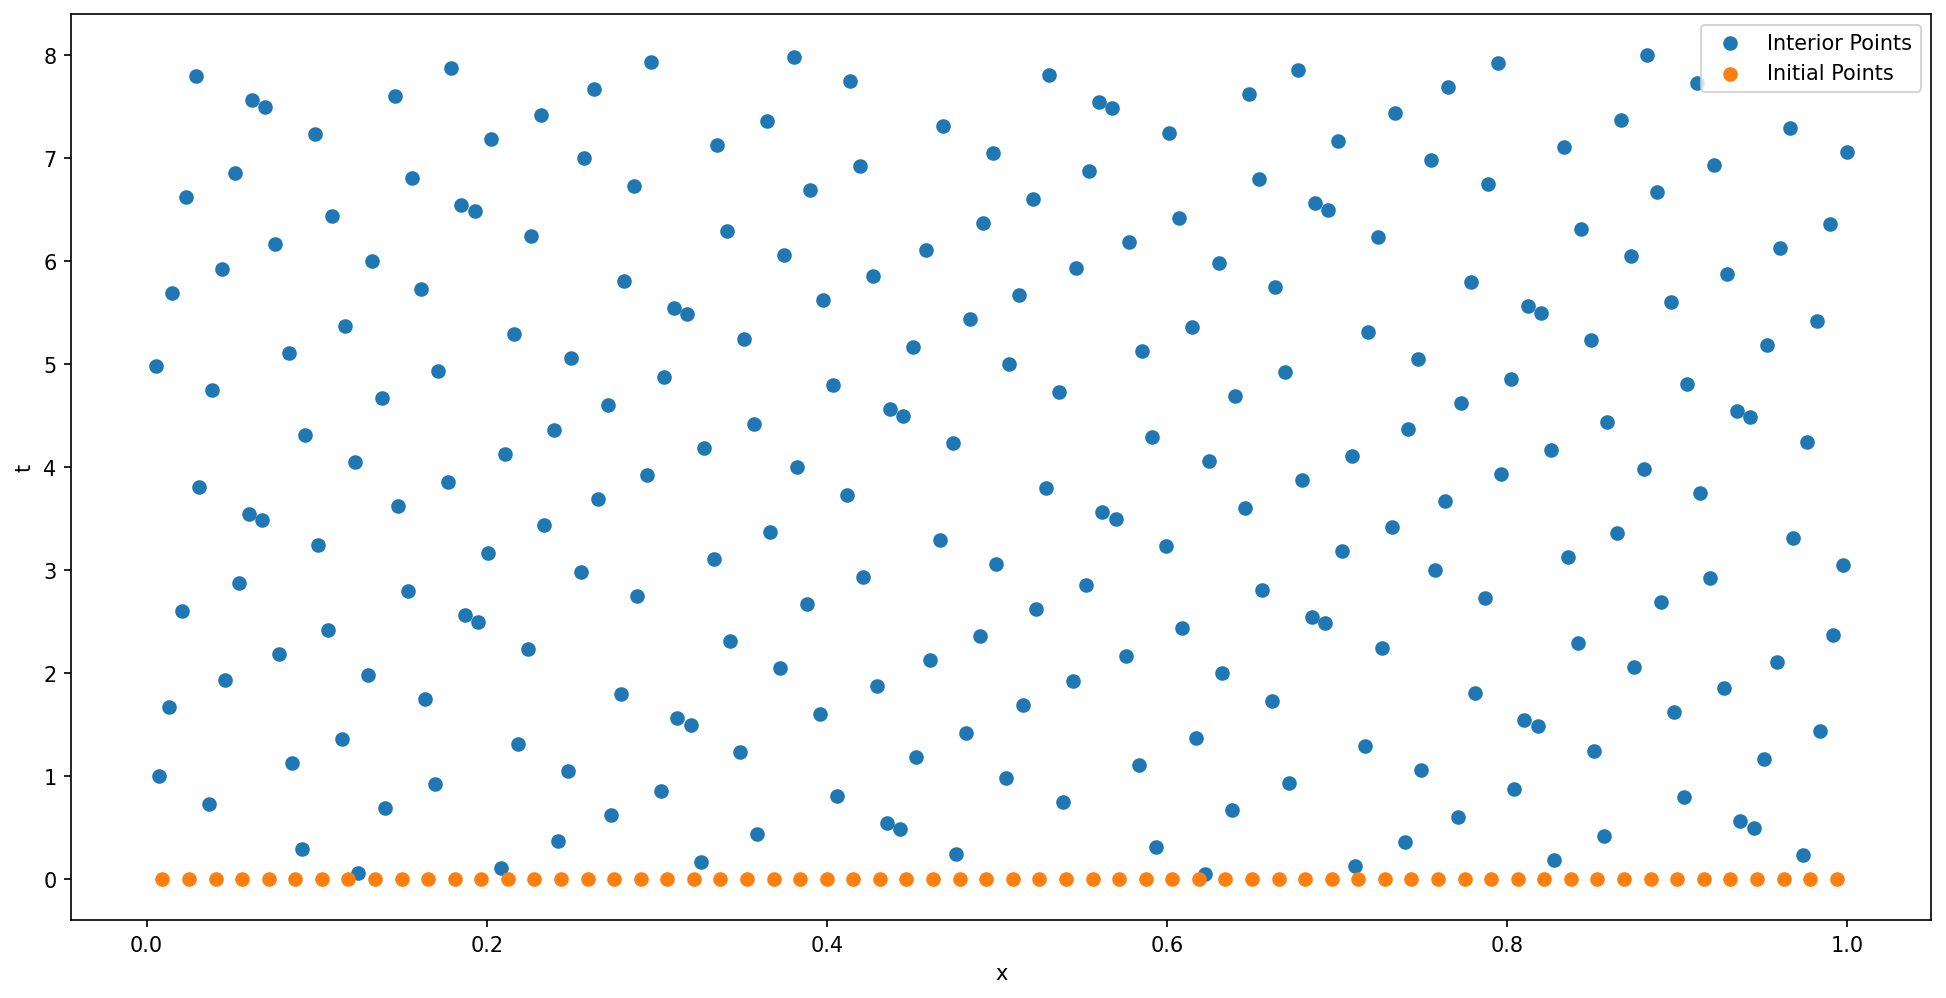

In [71]:
# Plot the input training points
#input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
#plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [72]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=200,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

In [73]:
hist = pinn.fit(num_epochs=n_epochs, optimizer=optimizer_LBFGS, verbose=False)

RuntimeError: The size of tensor a (64) must match the size of tensor b (2) at non-singleton dimension 1

NameError: name 'hist' is not defined

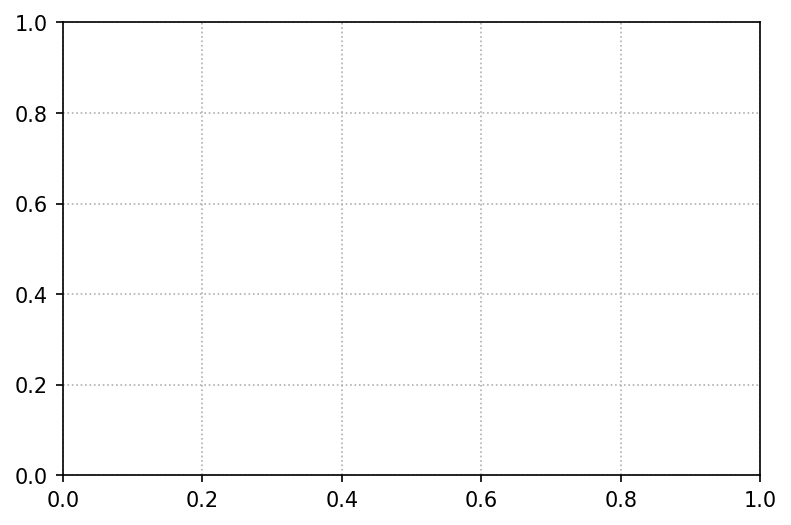

In [62]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

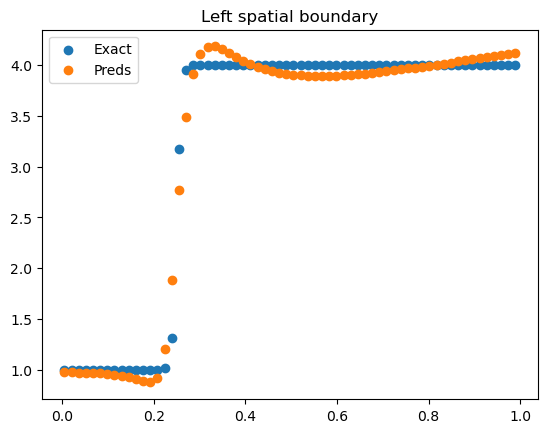

In [11]:
pinn.plot_boundary(pinn.add_left_spatial_boundary_points(), 'Left spatial boundary')

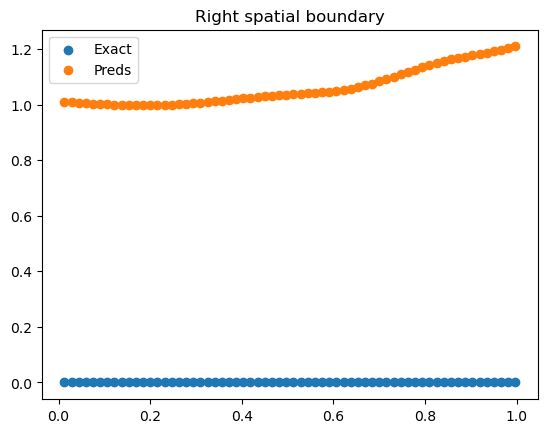

In [12]:
pinn.plot_boundary(pinn.add_right_spatial_boundary_points(), 'Right spatial boundary')

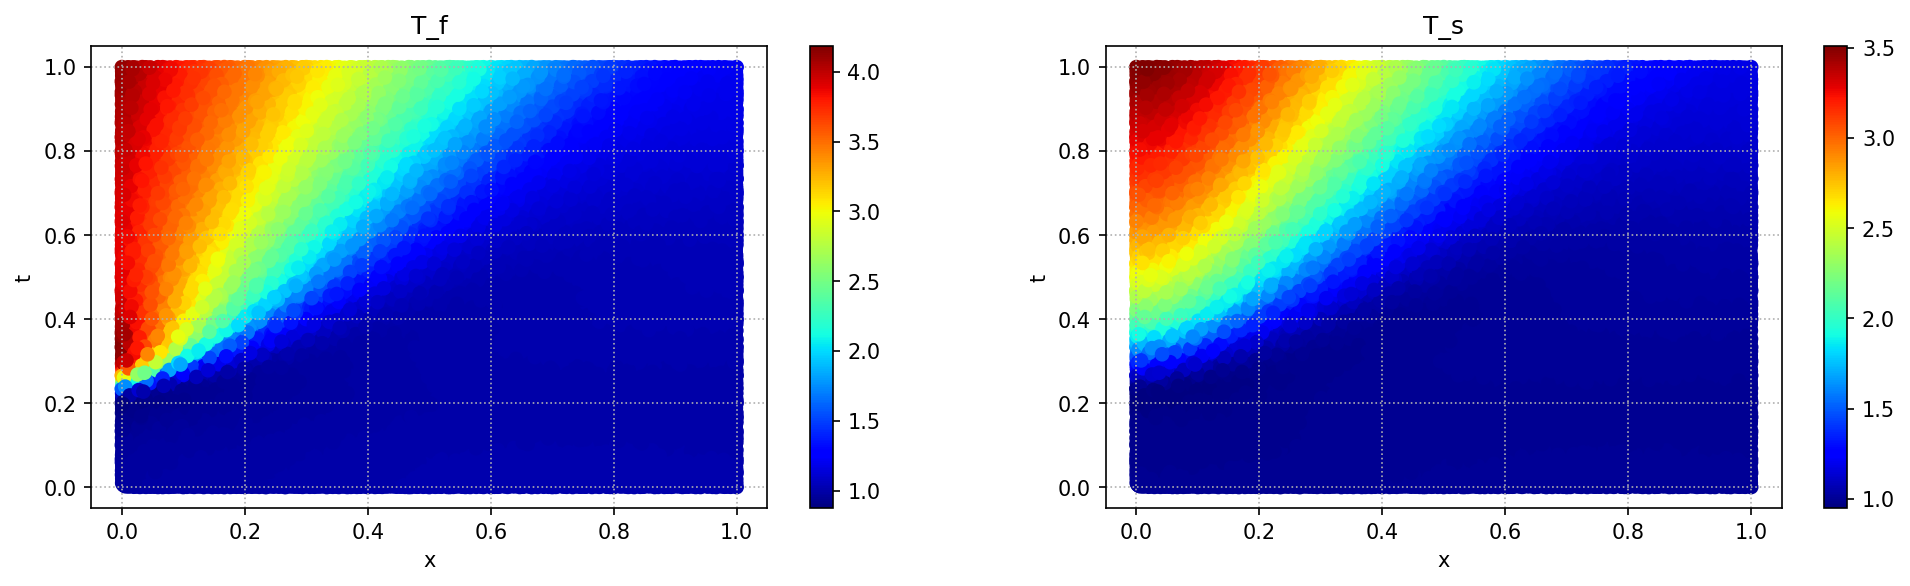

In [13]:
pinn.plotting()